In [1]:
!pip install pennylane

In [2]:
import numpy as np
import pennylane as qml
import torch

import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.data import DataLoader

In [4]:
def data_shape_transform(data, n_qubits=8):
  data = torch.reshape(data, (-1, 1))
  out = []
  col_num = int(np.ceil(len(data)/n_qubits))
  for i in range(n_qubits):
    tmp = []
    for j in range(col_num):
      if i*col_num+j >= len(data):
        break

      tmp.append(data[i*col_num+j])

    out.append(tmp)

  # print(out)
  return out, len(data)

def data_embedding(data, n_qubits=8):
  data, data_len = data_shape_transform(data, n_qubits=n_qubits)

  flag = 1
  col_num = int(np.ceil(data_len/n_qubits))
  qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")

  for j in range(col_num):
    for i in range(n_qubits):
      if i*col_num+j >= data_len:
        break

      if flag == 1:
        qml.RZ(data[i][j], wires=i)
      else:
        qml.RX(data[i][j], wires=i)

    flag *= -1


def apply_weights(weights, n_qubits=8):
  for i in range(len(weights)):

    for j in range(n_qubits):
      qml.RZ(weights[i][j], wires=j)

    index = j
    flag = 1
    for k in range(n_qubits):
      for j in range(n_qubits):
        if k == j:
          continue
        index += 1
        if flag == 1:
          qml.CRX(weights[i][index], wires=[k, j])
        else:
          qml.CRY(weights[i][index], wires=[k, j])

      flag *= -1

    for j in range(n_qubits):
      qml.RZ(weights[i][index+j], wires=j)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, X in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, X)

        loss.backward()
        optimizer.step()

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

def train(model, train_dataloader, epochs, loss_fn, optimizer):
    accuracy_hist = []
    loss_hist = []

    for epoch in range(epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer)
        if epoch % 1 == 0:
          print(f"Epoch {epoch+1}\n-------------------------------")
          loss = test_loop(train_dataloader, model, loss_fn)
          loss_hist.append(loss)

    print("Finish")
    return accuracy_hist, loss_hist

In [6]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

In [7]:
@qml.qnode(dev, interface="torch")
def c1(inputs, weights):
  data_embedding(inputs, n_qubits=8)
  apply_weights(weights, n_qubits=8)

  return qml.probs(wires=range(n_qubits))

In [8]:
class Q1Layer(torch.nn.Module):

    def __init__(self, circuit=None, n_qubits=8, q_depth=1):
        super().__init__()

        n_args = (q_depth, n_qubits**2 + n_qubits)
        weight_shapes = {"weights": n_args}
        self.qlayer_1 = qml.qnn.TorchLayer(circuit, weight_shapes)

    def forward(self, input_):
        q = self.qlayer_1(inputs=input_[0])
        q = q.unsqueeze(0)
        q = torch.reshape(q, (1, 16, 16))
        return q

In [9]:
data = pd.read_excel('prepared_dataset.xlsx')
data = pd.DataFrame(data).to_numpy()

data = np.reshape(data, (len(data), 16, 16))

batch_size = 1
data = torch.tensor(data, requires_grad=True).float()
train_dataloader = DataLoader(data, batch_size=batch_size)

In [10]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 5, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 8, out_channels = 5, kernel_size = 3, stride=1, padding="valid"),
    torch.nn.ReLU(),
    torch.nn.Flatten(),

    Q1Layer(circuit=c1, n_qubits=8, q_depth=10),

    torch.nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride=1, padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels = 8, out_channels = 1, kernel_size = 3, stride=1, padding="same"),
    torch.nn.ReLU()
)

for param in model.parameters():
  param.requires_grad = True

In [11]:
lr = 0.008
epochs = 150

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss_fn = torch.nn.L1Loss()

In [14]:
for epoch in range(epochs):

    running_loss = 0
    size = len(train_dataloader)

    for x in train_dataloader:
        optimizer.zero_grad()

        loss_evaluated = loss_fn(model(x), x)
        loss_evaluated.backward()

        optimizer.step()

        running_loss += loss_evaluated

    scheduler.step()
    avg_loss = running_loss/size
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.2441
Average loss over epoch 2: 0.2395
Average loss over epoch 3: 0.2352
Average loss over epoch 4: 0.2306
Average loss over epoch 5: 0.2262
Average loss over epoch 6: 0.2234
Average loss over epoch 7: 0.2194
Average loss over epoch 8: 0.2180
Average loss over epoch 9: 0.2134
Average loss over epoch 10: 0.2106
Average loss over epoch 11: 0.2061
Average loss over epoch 12: 0.2004
Average loss over epoch 13: 0.1957
Average loss over epoch 14: 0.1910
Average loss over epoch 15: 0.1856
Average loss over epoch 16: 0.1813
Average loss over epoch 17: 0.1765
Average loss over epoch 18: 0.1727
Average loss over epoch 19: 0.1679
Average loss over epoch 20: 0.1641
Average loss over epoch 21: 0.1601
Average loss over epoch 22: 0.1559
Average loss over epoch 23: 0.1525
Average loss over epoch 24: 0.1492
Average loss over epoch 25: 0.1462
Average loss over epoch 26: 0.1424
Average loss over epoch 27: 0.1391
Average loss over epoch 28: 0.1368
Average loss over epoch 29: 0

In [15]:
test_loop(train_dataloader, model, loss_fn)

Avg loss: 0.036557 



0.03655661642551422

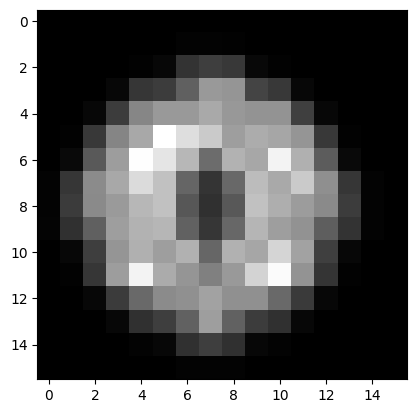

In [19]:
index = 1
plt.imshow(data[index].detach().numpy(), cmap='gray')

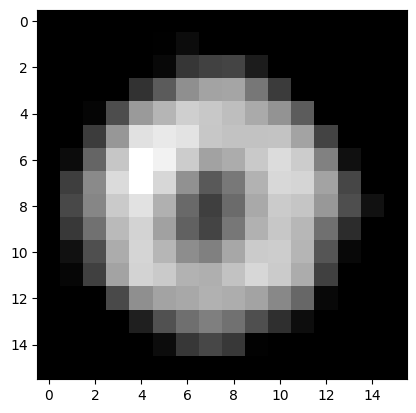

In [20]:
out = model(data[index].expand(1, 16, 16))
out = torch.reshape(out, (16, 16))

plt.imshow(out.detach().numpy(), cmap='gray')